In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...


In [2]:
# Loading the dataset
df = pd.read_csv("../data/raw/blogtext.csv", nrows=10000)
print(df.shape)

(10000, 7)


In [3]:
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [4]:
df.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

In [5]:
df.isnull().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10000.0,1.854823e+06,1.303245e+06,467705.0,649790.0,1103575.0,3176655.0,4321554.0
age,10000.0,2.801930e+01,8.123923e+00,13.0,23.0,27.0,35.0,46.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  int64 
 1   gender  10000 non-null  object
 2   age     10000 non-null  int64 
 3   topic   10000 non-null  object
 4   sign    10000 non-null  object
 5   date    10000 non-null  object
 6   text    10000 non-null  object
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [8]:
# Creating a new dataframe with two columns
df = df[["sign", "text"]]

In [9]:
print(df.shape)

(10000, 2)


In [10]:
pd.set_option("display.max_colwidth", 100)
df.head()

,sign,text
0,Leo,"Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait unti..."
1,Leo,These are the team members: Drewes van der Laag urlLink mail Ruiyu Xie ...
2,Leo,In het kader van kernfusie op aarde: MAAK JE EIGEN WATERSTOFBOM How to build an H-...
3,Leo,testing!!! testing!!!
4,Aquarius,Thanks to Yahoo!'s Toolbar I can now 'capture' the URLs of popups...which means now...


In [11]:
# Checking how many unique signs are there
pd.DataFrame(df.sign.unique()).values

array([['Leo'],
       ['Aquarius'],
       ['Aries'],
       ['Capricorn'],
       ['Gemini'],
       ['Cancer'],
       ['Sagittarius'],
       ['Scorpio'],
       ['Libra'],
       ['Virgo'],
       ['Taurus'],
       ['Pisces']], dtype=object)

In [12]:
# Create a new column 'sign_id' with encoded signs 
df["sign_id"] = df["sign"].factorize()[0]
sign_id_df = df[["sign", "sign_id"]].drop_duplicates()

In [13]:
# Dictionaries for future use
sign_to_id = dict(sign_id_df.values)
id_to_sign = dict(sign_id_df[["sign_id", "sign"]].values)

# New dataframe
df.head()

,sign,text,sign_id
0,Leo,"Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait unti...",0
1,Leo,These are the team members: Drewes van der Laag urlLink mail Ruiyu Xie ...,0
2,Leo,In het kader van kernfusie op aarde: MAAK JE EIGEN WATERSTOFBOM How to build an H-...,0
3,Leo,testing!!! testing!!!,0
4,Aquarius,Thanks to Yahoo!'s Toolbar I can now 'capture' the URLs of popups...which means now...,1


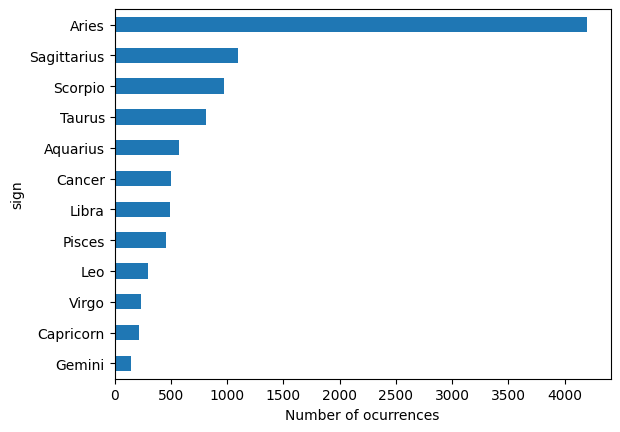

In [14]:
# Visualize the data
fig = plt.figure()
df.groupby("sign").text.count().sort_values().plot.barh(ylim=0)
plt.xlabel("Number of ocurrences", fontsize = 10);

In [15]:
# Pre-processing the "text" column

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
# removing punctuation
def remove_punctuation(text):
    text = "".join([c for c in text if c not in string.punctuation])
    return text

df["text"] = df["text"].apply(lambda x: remove_punctuation(x))
df.head(2)

,sign,text,sign_id
0,Leo,Info has been found 100 pages and 45 MB of pdf files Now i have to wait untill our t...,0
1,Leo,These are the team members Drewes van der Laag urlLink mail Ruiyu Xie ...,0


In [18]:
# removing unwanted characters
df["text"] = df["text"].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', " ", x))

In [19]:
# removing whitespaces (begining and trailing spaces)
df["text"] = df["text"].apply(lambda x: x.strip())

In [20]:
# replacing more than 1 spaces with single space
df["text"] = df["text"].str.replace(r"\s\s+", " ")

In [21]:
# tokenization
def tokenize(text):
    tokens = re.split("\W+", text)
    return tokens

df["text"] = df["text"].apply(lambda x: tokenize(x.lower()))
df.head()

,sign,text,sign_id
0,Leo,"[info, has, been, found, 100, pages, and, 45, mb, of, pdf, files, now, i, have, to, wait, untill...",0
1,Leo,"[these, are, the, team, members, drewes, van, der, laag, urllink, mail, ruiyu, xie, urllink, mai...",0
2,Leo,"[in, het, kader, van, kernfusie, op, aarde, maak, je, eigen, waterstofbom, how, to, build, an, h...",0
3,Leo,"[testing, testing]",0
4,Aquarius,"[thanks, to, yahoos, toolbar, i, can, now, capture, the, urls, of, popupswhich, means, now, i, c...",1


In [22]:
# removing stopwords
stopwords = nltk.corpus.stopwords.words("english")
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [23]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text

df["text"] = df["text"].apply(lambda x: remove_stopwords(x))
df.head()

,sign,text,sign_id
0,Leo,"[info, found, 100, pages, 45, mb, pdf, files, wait, untill, team, leader, processed, learns, html]",0
1,Leo,"[team, members, drewes, van, der, laag, urllink, mail, ruiyu, xie, urllink, mail, bryan, aalderi...",0
2,Leo,"[het, kader, van, kernfusie, op, aarde, maak, je, eigen, waterstofbom, build, hbomb, ascotttarta...",0
3,Leo,"[testing, testing]",0
4,Aquarius,"[thanks, yahoos, toolbar, capture, urls, popupswhich, means, show, cool, links, korean, pop, kpo...",1


In [24]:
wn = nltk.WordNetLemmatizer()

In [25]:
# lemmatization
def lemmatization(text):
    text = [wn.lemmatize(word) for word in text]
    return " ".join(text)

df["text"] = df["text"].apply(lambda x: lemmatization(x))
df.head()

,sign,text,sign_id
0,Leo,info found 100 page 45 mb pdf file wait untill team leader processed learns html,0
1,Leo,team member drewes van der laag urllink mail ruiyu xie urllink mail bryan aaldering urllink mail,0
2,Leo,het kader van kernfusie op aarde maak je eigen waterstofbom build hbomb ascotttartarusuwaeduau a...,0
3,Leo,testing testing,0
4,Aquarius,thanks yahoo toolbar capture url popupswhich mean show cool link korean pop kpop audio video wit...,1
